In [31]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

import seaborn as sns
from scipy import stats

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Implement 1st ML Classifier: Random Forest

In [32]:
import pandas as pd

internet_data = pd.read_csv('preprocessed_internet_data.csv')

internet_data

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes Sent,Bytes Received,Elapsed Time (sec),Packets Sent,Packets Received,Action
0,57222,53,54587,53,4.553877,4.430817,30,0.693147,0.693147,0
1,56258,3389,56258,3389,7.378384,8.061171,17,2.397895,2.397895,0
2,6881,50321,43265,50321,4.779123,4.795791,1199,0.693147,0.693147,0
3,50553,3389,50553,3389,7.271704,7.544332,17,2.197225,2.197225,0
4,50002,443,45848,443,8.821585,9.829895,16,2.639057,2.639057,0
...,...,...,...,...,...,...,...,...,...,...
65527,63691,80,13237,80,5.262690,4.812184,15,1.609438,1.609438,0
65528,50964,80,13485,80,11.117109,15.344482,77,6.893656,6.893656,0
65529,54871,445,0,0,4.262680,0.000000,0,0.693147,0.693147,2
65530,54870,445,0,0,4.262680,0.000000,0,0.693147,0.693147,2


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

In [34]:
X = internet_data.drop('Action', axis=1)  
y = internet_data['Action']

In [35]:
nat_ports = internet_data['NAT Source Port']
nat_ports

target_variable = y 

relationship_df = pd.DataFrame({
    'nat source port': nat_ports,
    'Target': target_variable
})

relationship_df

,nat source port,Target
0,54587,0
1,56258,0
2,43265,0
3,50553,0
4,45848,0
...,...,...
65527,13237,0
65528,13485,0
65529,0,2
65530,0,2


In [36]:
print(y.value_counts())

Action
0    37640
1    14987
2    12851
3       54
Name: count, dtype: int64


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

1. Random Forest

Let's first assess feature importance so we can figure out which features contribute the most to our model's performance

Average Metrics across folds:
  Score: 0.9923
                Feature  Importance
2       NAT Source Port    0.264373
6    Elapsed Time (sec)    0.248164
3  NAT Destination Port    0.186932
1      Destination Port    0.115685
4            Bytes Sent    0.082140
5        Bytes Received    0.063737
0           Source Port    0.030913
8      Packets Received    0.004078
7          Packets Sent    0.003978


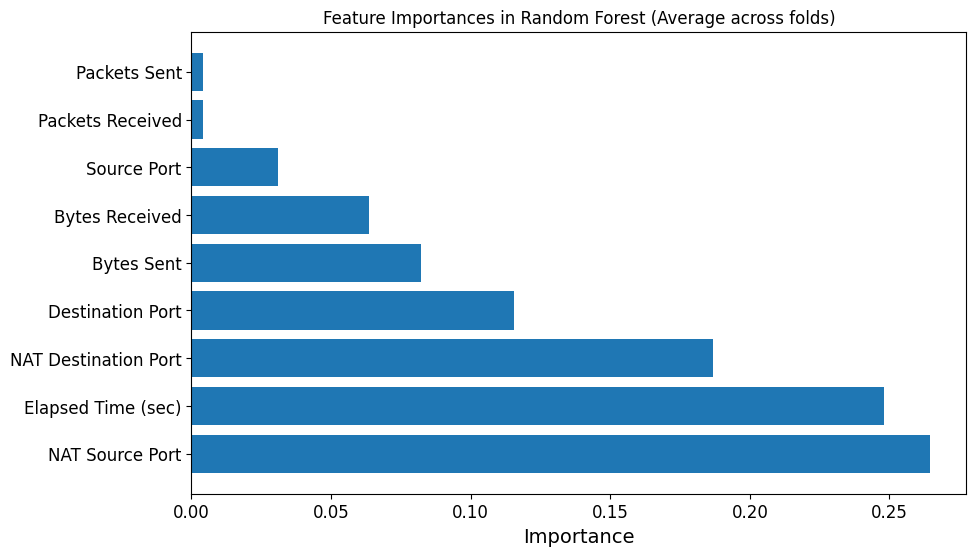

In [38]:
model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=2)

# Stratified KFold cross-validation
skf = StratifiedKFold(n_splits=5)

# Store feature importances for each fold
feature_importances = []

cv_results = cross_validate(model, X, y, cv=skf, return_estimator=True)

for estimator in cv_results['estimator']:
    feature_importances.append(estimator.feature_importances_)

# Calculate and display mean metrics
mean_metrics = {key: np.mean(values) for key, values in cv_results.items() if key.startswith('test_')}
print("Average Metrics across folds:")
for metric, value in mean_metrics.items():
    print(f"  {metric.replace('test_', '').capitalize()}: {value:.4f}")

# Convert the list of feature importances to a DataFrame for easier interpretation
feature_importances = np.array(feature_importances)

# Average the feature importances across folds
mean_importances = feature_importances.mean(axis=0)

# Create a DataFrame with feature names and their corresponding importances
feature_names = X.columns  
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances in Random Forest (Average across folds)')
plt.show()

Interpreting the feature importance graph, we see that the two most important features are NAT Source Port and Elapsed Time. Let's use random forest with a depth of 2 and a singular decision tree with a depth of 2 to test the accuracy of our model using these features. 

We see that there is not much of a difference between the accuracy of the single decision tree and random forest. We can consider using one decision tree for this data since it computationally inexpensive, especially with a depth of 2. 

Metrics for Decision Tree:
  Precision: 0.9925
  Recall: 0.9919
  F1-Score: 0.9919
  AUC: 0.9135

Metrics for Random Forest:
  Precision: 0.9888
  Recall: 0.9876
  F1-Score: 0.9873
  AUC: 0.9733


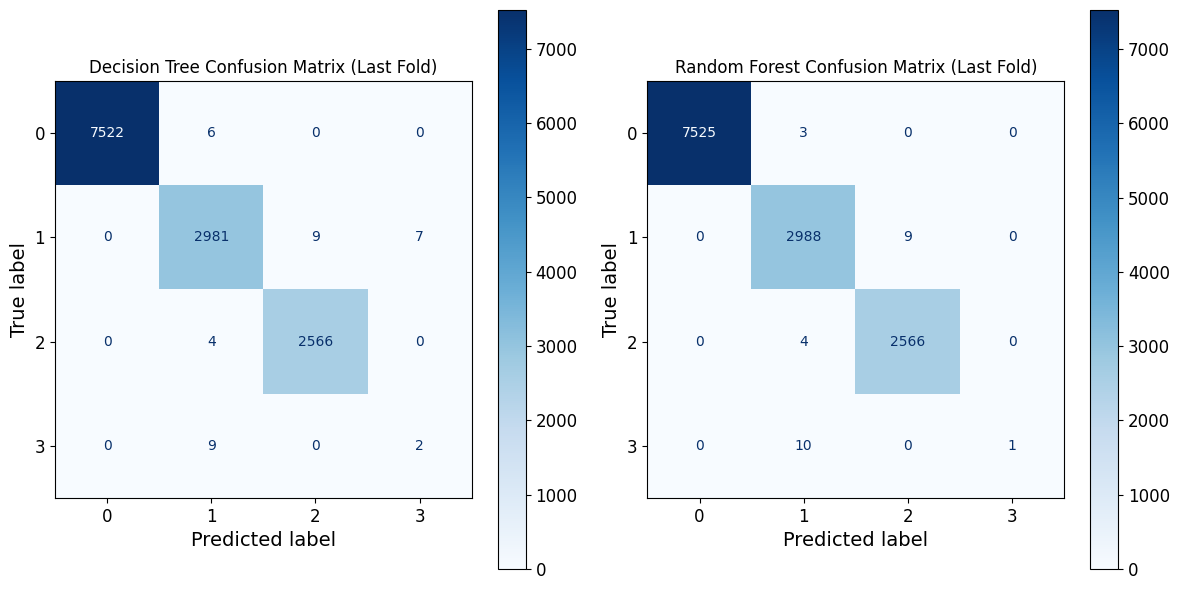

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay


# Initialize lists to store metrics and confusion matrices
tree_metrics = []
rf_metrics = []
tree_conf_matrices = []
rf_conf_matrices = []

tree_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()

for train_index, test_index in skf.split(X, y):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train and predict with Decision Tree
    tree_model.fit(X_train, y_train)
    tree_preds = tree_model.predict(X_test)
    tree_probs = tree_model.predict_proba(X_test)[:, 1] if len(tree_model.classes_) == 2 else tree_model.predict_proba(X_test)
    tree_conf_matrices.append(confusion_matrix(y_test, tree_preds))

    # Compute metrics for Decision Tree
    tree_precision = precision_score(y_test, tree_preds, average='weighted')
    tree_recall = recall_score(y_test, tree_preds, average='weighted')
    tree_f1 = f1_score(y_test, tree_preds, average='weighted')
    tree_auc = roc_auc_score(y_test, tree_probs, multi_class='ovr') if len(tree_model.classes_) > 2 else roc_auc_score(y_test, tree_probs)
    tree_metrics.append((tree_precision, tree_recall, tree_f1, tree_auc))

    # Train and predict with Random Forest
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)
    rf_probs = rf_model.predict_proba(X_test)[:, 1] if len(rf_model.classes_) == 2 else rf_model.predict_proba(X_test)
    rf_conf_matrices.append(confusion_matrix(y_test, rf_preds))

    # Compute metrics for Random Forest
    rf_precision = precision_score(y_test, rf_preds, average='weighted')
    rf_recall = recall_score(y_test, rf_preds, average='weighted')
    rf_f1 = f1_score(y_test, rf_preds, average='weighted')
    rf_auc = roc_auc_score(y_test, rf_probs, multi_class='ovr') if len(rf_model.classes_) > 2 else roc_auc_score(y_test, rf_probs)
    rf_metrics.append((rf_precision, rf_recall, rf_f1, rf_auc))

# Calculate averages across folds for both models
tree_avg_metrics = pd.DataFrame(tree_metrics, columns=["Precision", "Recall", "F1-Score", "AUC"]).mean()
rf_avg_metrics = pd.DataFrame(rf_metrics, columns=["Precision", "Recall", "F1-Score", "AUC"]).mean()

# Print average metrics for both models
print("Metrics for Decision Tree:")
print(f"  Precision: {tree_avg_metrics['Precision']:.4f}")
print(f"  Recall: {tree_avg_metrics['Recall']:.4f}")
print(f"  F1-Score: {tree_avg_metrics['F1-Score']:.4f}")
print(f"  AUC: {tree_avg_metrics['AUC']:.4f}")
print()
print("Metrics for Random Forest:")
print(f"  Precision: {rf_avg_metrics['Precision']:.4f}")
print(f"  Recall: {rf_avg_metrics['Recall']:.4f}")
print(f"  F1-Score: {rf_avg_metrics['F1-Score']:.4f}")
print(f"  AUC: {rf_avg_metrics['AUC']:.4f}")

# Display confusion matrices for the last fold
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay(tree_conf_matrices[-1], display_labels=tree_model.classes_).plot(ax=axes[0], cmap="Blues")
axes[0].set_title("Decision Tree Confusion Matrix (Last Fold)")

ConfusionMatrixDisplay(rf_conf_matrices[-1], display_labels=rf_model.classes_).plot(ax=axes[1], cmap="Blues")
axes[1].set_title("Random Forest Confusion Matrix (Last Fold)")

plt.tight_layout()
plt.show()

2. K-Nearest Neighbor

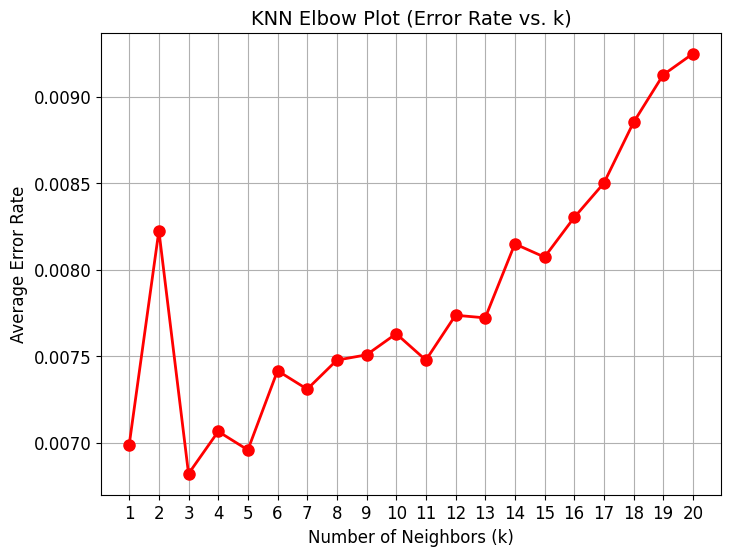

<Figure size 640x480 with 0 Axes>

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# Range of k values to test
k_range = range(1, 21)  

# Stratified K-Fold Cross-Validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store the error rate for each k
knn_error_rates = []

# Stratified K-Fold Cross-Validation for each k value
for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    fold_errors = [] 

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        knn_model.fit(X_train, y_train)
        knn_preds = knn_model.predict(X_test)

        fold_errors.append(1 - accuracy_score(y_test, knn_preds))

    # Average error rate for this value of k
    knn_error_rates.append(np.mean(fold_errors))

# Plot the elbow curve to find the best value for k
plt.figure(figsize=(8, 6))
plt.plot(k_range, knn_error_rates, marker='o', color='r', linestyle='-', linewidth=2, markersize=8)
plt.title('KNN Elbow Plot (Error Rate vs. k)', fontsize=14)
plt.xlabel('Number of Neighbors (k)', fontsize=12)
plt.ylabel('Average Error Rate', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()

plt.savefig("KNN_Elbow_Plot.png")
plt.show()

The lowest error rate for k looks to be 3, although all the values for k seem to have low error rates. We will stick with k = 3 for this model.

C:\Users\tromb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tromb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Average Metrics for KNN (k=3):
  Precision: 0.9916
  Recall: 0.9923
  F1-Score: 0.9919
  AUC: 0.8959


<Figure size 600x600 with 0 Axes>

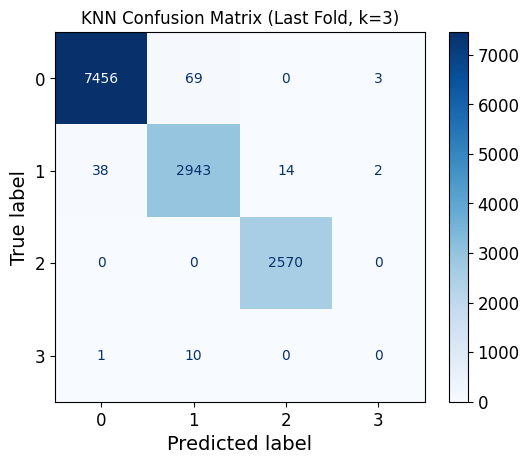

In [41]:
# Initialize KNN model with 3 neighbors
k_neighbors = 3
knn_model = KNeighborsClassifier(n_neighbors=k_neighbors)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Lists to store metrics and confusion matrices
knn_metrics = []
knn_conf_matrices = []

for train_index, test_index in skf.split(X, y):
    # Split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the KNN model and make predictions
    knn_model.fit(X_train, y_train)
    knn_preds = knn_model.predict(X_test)
    knn_probs = knn_model.predict_proba(X_test)[:, 1] if len(knn_model.classes_) == 2 else knn_model.predict_proba(X_test)

    # Compute metrics
    knn_precision = precision_score(y_test, knn_preds, average='weighted')
    knn_recall = recall_score(y_test, knn_preds, average='weighted')
    knn_f1 = f1_score(y_test, knn_preds, average='weighted')
    knn_auc = roc_auc_score(y_test, knn_probs, multi_class='ovr') if len(knn_model.classes_) > 2 else roc_auc_score(y_test, knn_probs)
    
    knn_metrics.append((knn_precision, knn_recall, knn_f1, knn_auc))
    knn_conf_matrices.append(confusion_matrix(y_test, knn_preds))

# Calculate average metrics
knn_avg_metrics = pd.DataFrame(knn_metrics, columns=["Precision", "Recall", "F1-Score", "AUC"]).mean()

# Print average metrics
print(f"Average Metrics for KNN (k={k_neighbors}):")
print(f"  Precision: {knn_avg_metrics['Precision']:.4f}")
print(f"  Recall: {knn_avg_metrics['Recall']:.4f}")
print(f"  F1-Score: {knn_avg_metrics['F1-Score']:.4f}")
print(f"  AUC: {knn_avg_metrics['AUC']:.4f}")

# Display the confusion matrix for the last fold
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay(knn_conf_matrices[-1], display_labels=knn_model.classes_).plot(cmap="Blues")
plt.title(f"KNN Confusion Matrix (Last Fold, k={k_neighbors})")
plt.show()

3.  Support Vector Machines

In [42]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train, y_train)
predictions = svm_model.predict(X_test)

acc_score = accuracy_score(y_test, predictions)
print(f'SVM accuracy score: {acc_score:.4f}')

SVM accuracy score: 0.9760


Because we get a high accuracy, we can verify this by doing k-fold cross validation

C:\Users\tromb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tromb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\tromb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

Average Metrics for SVM:
  Precision: 0.9796
  Recall: 0.9795
  F1-Score: 0.9793
  AUC: 0.9443


C:\Users\tromb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 600x600 with 0 Axes>

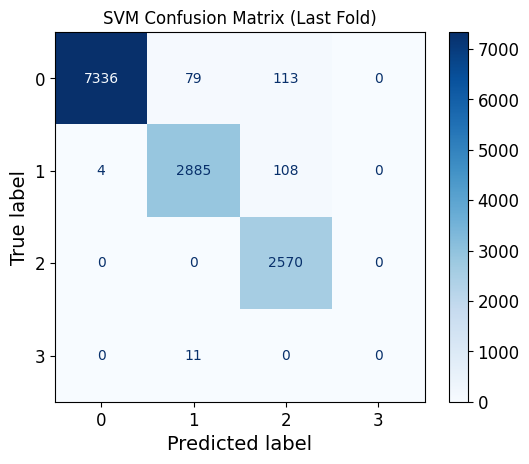

In [43]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold

# Initialize SVM with probability=True for AUC computation
svm_model = SVC(probability=True, kernel='rbf', random_state=42)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)

# Lists to store metrics and confusion matrices
svm_metrics = []
svm_conf_matrices = []

for train_index, test_index in skf.split(X, y):
    # Split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the SVM model and make predictions
    svm_model.fit(X_train, y_train)
    svm_preds = svm_model.predict(X_test)
    svm_probs = svm_model.predict_proba(X_test)  

    # Compute metrics
    svm_precision = precision_score(y_test, svm_preds, average='weighted')
    svm_recall = recall_score(y_test, svm_preds, average='weighted')
    svm_f1 = f1_score(y_test, svm_preds, average='weighted')
    svm_auc = roc_auc_score(
        LabelBinarizer().fit_transform(y_test), svm_probs, multi_class='ovr'
    )

    # Append metrics for this fold
    svm_metrics.append((svm_precision, svm_recall, svm_f1, svm_auc))
    svm_conf_matrices.append(confusion_matrix(y_test, svm_preds))

# Calculate average metrics
svm_avg_metrics = pd.DataFrame(svm_metrics, columns=["Precision", "Recall", "F1-Score", "AUC"]).mean()

# Print average metrics
print("Average Metrics for SVM:")
print(f"  Precision: {svm_avg_metrics['Precision']:.4f}")
print(f"  Recall: {svm_avg_metrics['Recall']:.4f}")
print(f"  F1-Score: {svm_avg_metrics['F1-Score']:.4f}")
print(f"  AUC: {svm_avg_metrics['AUC']:.4f}")

# Display the confusion matrix for the last fold
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay(svm_conf_matrices[-1], display_labels=svm_model.classes_).plot(cmap="Blues")
plt.title(f"SVM Confusion Matrix (Last Fold)")
plt.show()

Using SVM and what we determined to be the two most important features, we can see that this version model gives up 79% accuracy

In [44]:
from sklearn.svm import SVC
X2 = X[['NAT Source Port', 'Elapsed Time (sec)']] 
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
svm_model = SVC()
svm_model.fit(X_train, y_train)
predictions = svm_model.predict(X_test)
#print(X_train, y_train)

acc_score = accuracy_score(y_test, predictions)
print(f'SVM accuracy score: {acc_score:.4f}')

SVM accuracy score: 0.7942


4. Linear

In [45]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

score = linear_model.score(X_test, y_test)
print(f'linear model score: {score:.4f}')

linear model score: 0.7293


We can use K-fold cross validation to analyze our linear model. Here we see it has a high value for R² showing it explains a good amount of the variance in our data.

Average RMSE: 0.4122
Average R²: 0.7306


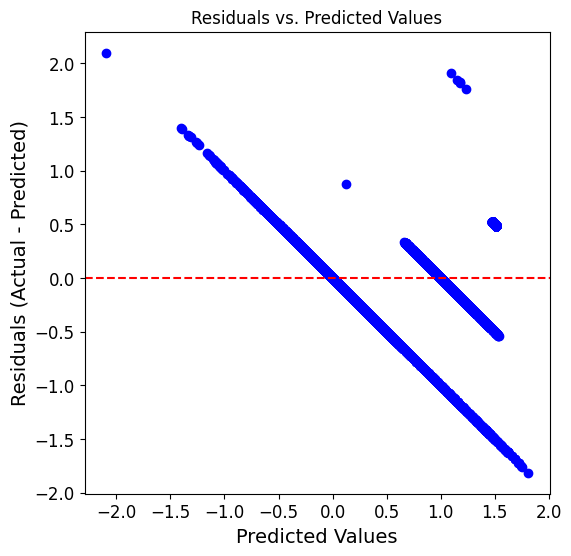

In [46]:

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score

# KFold cross-validation
kf = KFold(n_splits=5)

linear_accuracies = []
linear_conf_matrices = []
linear_rmse = []
linear_r2 = []

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    linear_model.fit(X_train, y_train)
    linear_preds = linear_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, linear_preds))
    r2 = r2_score(y_test, linear_preds)

    linear_rmse.append(rmse)
    linear_r2.append(r2)

avg_rmse = np.mean(linear_rmse)
avg_r2 = np.mean(linear_r2)

print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average R²: {avg_r2:.4f}")

# create a plot of the residuals vs predicted values
plt.figure(figsize=(6, 6))
plt.scatter(linear_preds, y_test - linear_preds, color='blue')
plt.axhline(y=0, color='r', linestyle='--')  # Reference line at y=0
plt.title("Residuals vs. Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.show()

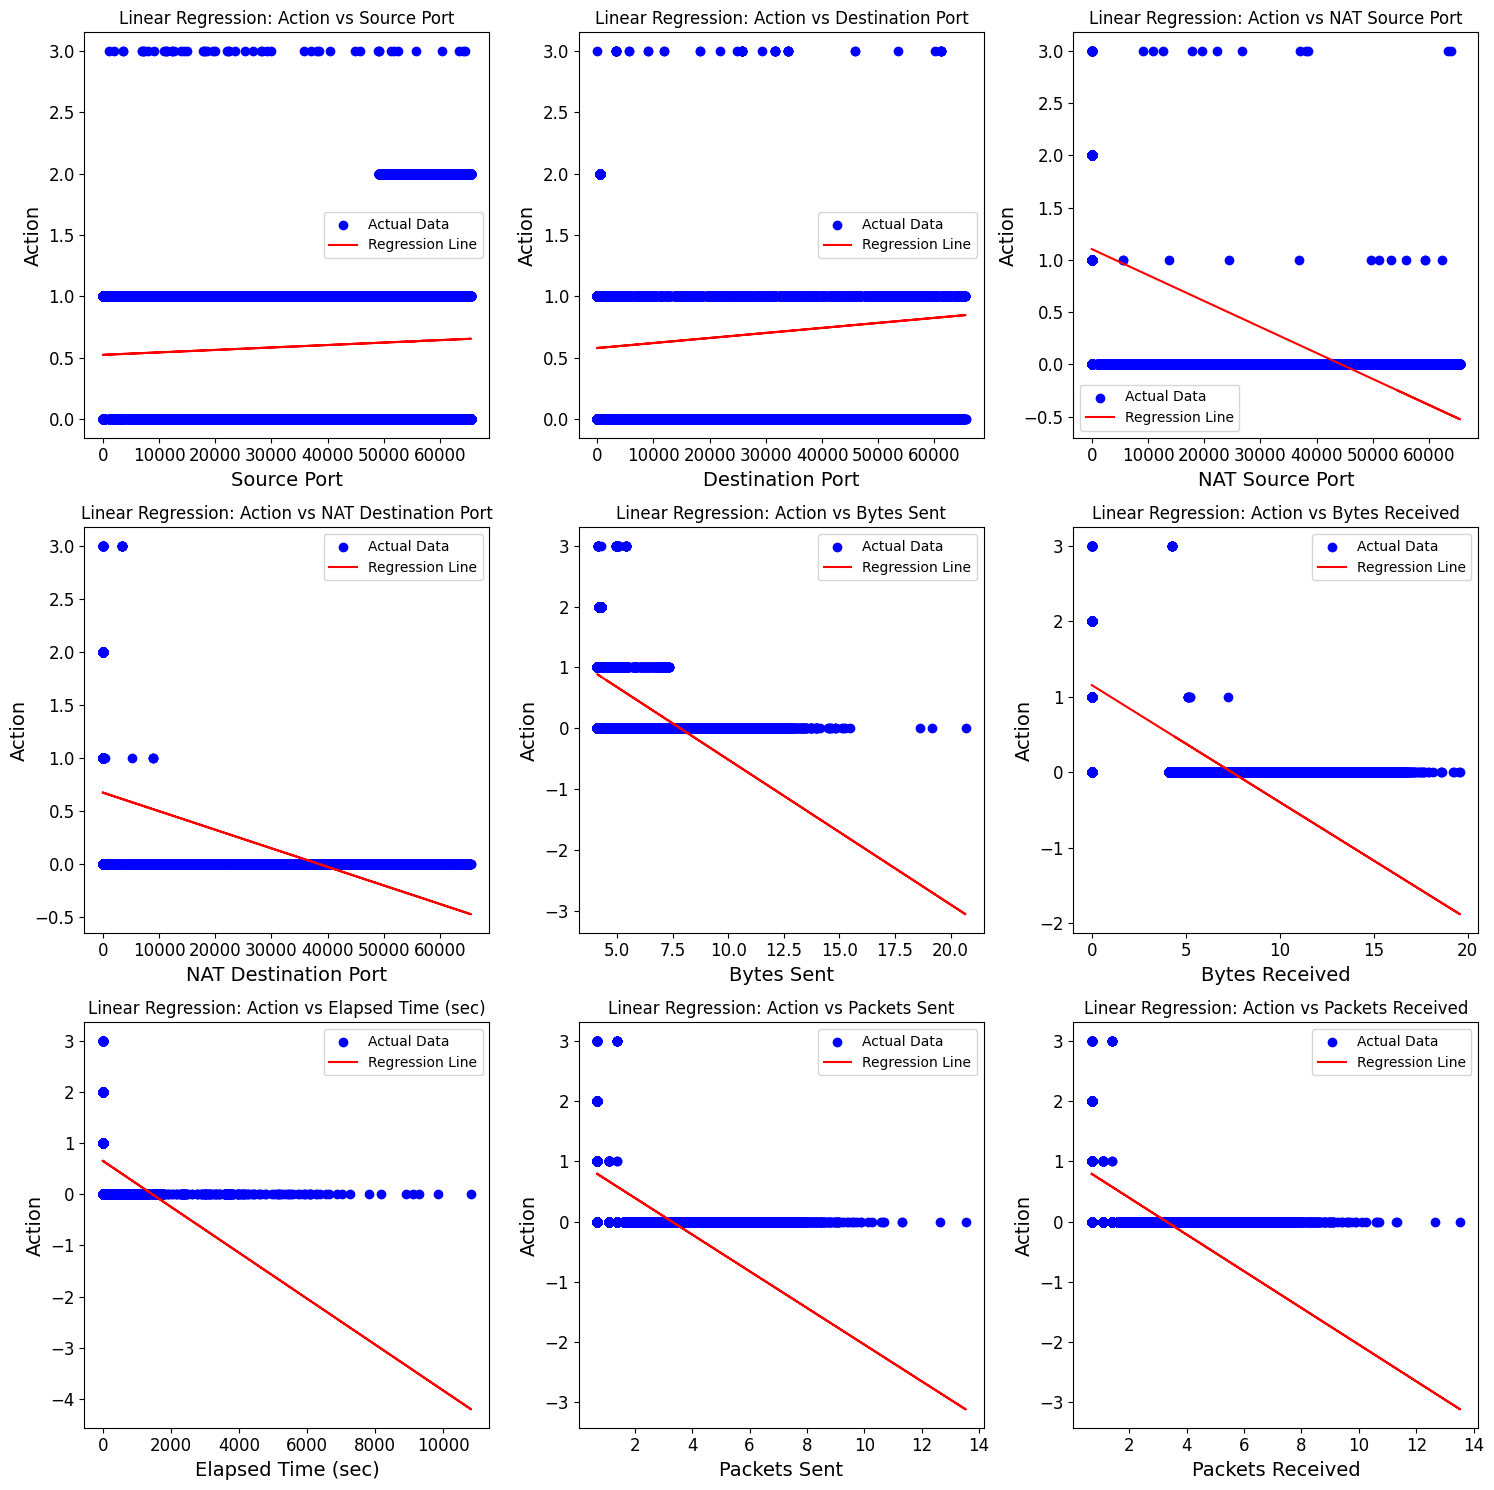

In [47]:
num_features = len(X.columns)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols  # Calculate number of rows to fit all features
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()


for idx, feature in enumerate(X.columns):
    
    linear_model.fit(internet_data[[feature]], y)
    y_pred = linear_model.predict(internet_data[[feature]])
  
    axes[idx].scatter(internet_data[feature], y, color='blue', label='Actual Data')
    axes[idx].plot(internet_data[feature], y_pred, color='red', label='Regression Line')
    
    axes[idx].set_title(f"Linear Regression: Action vs {feature}")
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel("Action")
    axes[idx].legend()

for idx in range(num_features, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

5. Logistic Regression

C:\Users\tromb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\tromb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics for Logistic Regression with PCA:
  Precision: 0.9765
  Recall: 0.9764
  F1-Score: 0.9763
  AUC: 0.9735


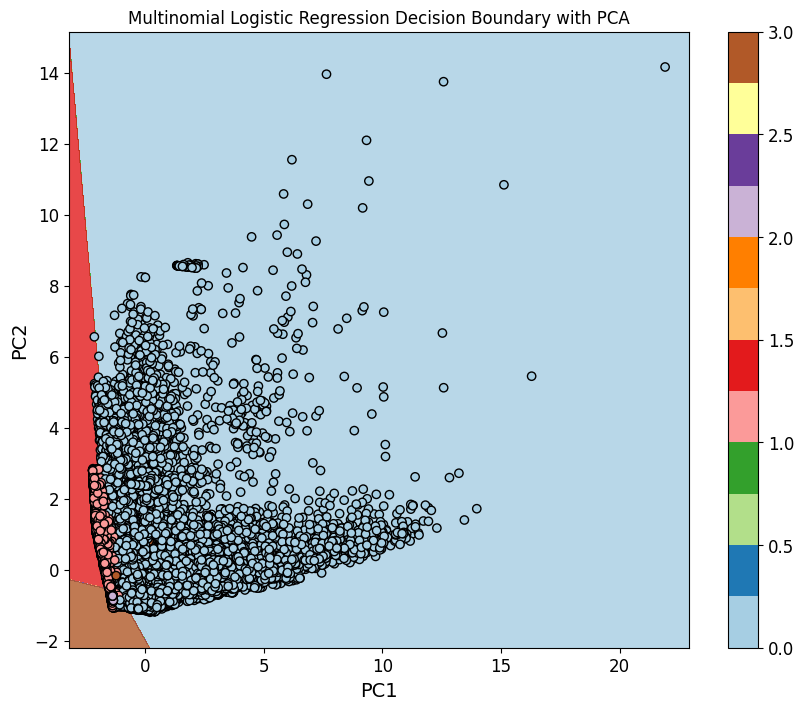

<Figure size 600x600 with 0 Axes>

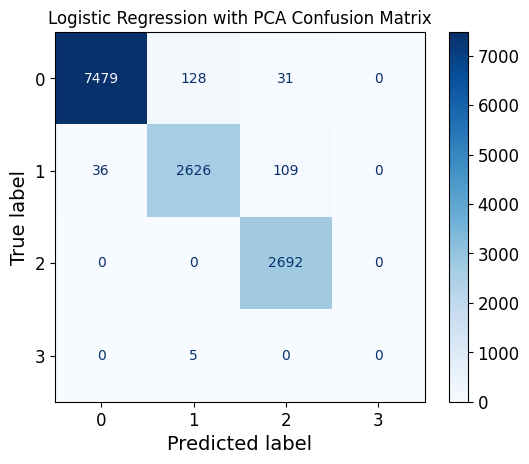

In [53]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train the Multinomial Logistic Regression model
model = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')
model.fit(X_train_pca, y_train)

# Predictions
y_test_preds = model.predict(X_test_pca)
y_test_probs = model.predict_proba(X_test_pca)

# Calculate metrics
precision = precision_score(y_test, y_test_preds, average='weighted')
recall = recall_score(y_test, y_test_preds, average='weighted')
f1 = f1_score(y_test, y_test_preds, average='weighted')

# AUC (for binary and multiclass)
if len(set(y_test)) > 2:  # Multiclass case
    auc = roc_auc_score(pd.get_dummies(y_test), y_test_probs, multi_class='ovr')
else:  # Binary case
    auc = roc_auc_score(y_test, y_test_probs[:, 1])

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_preds)

# Print metrics
print("Metrics for Logistic Regression with PCA:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  AUC: {auc:.4f}")

logistic_regression_avg_metrics = {'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC': auc}

# PCA decision boundary plot
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Paired)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', marker='o', cmap=plt.cm.Paired)
plt.title('Multinomial Logistic Regression Decision Boundary with PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

# Display Confusion Matrix
plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_).plot(cmap="Blues")
plt.title("Logistic Regression with PCA Confusion Matrix")
plt.show()

['Decision Tree', 'Random Forest', 'SVM', 'Logistic Regression']
[0.992503674471242, 0.9887525058419477, 0.979617862622608, 0.9764804831327335]
[0.9919431095322887, 0.9875790641981605, 0.9795213377791507, 0.9764230123607508]
[0.9918662167364746, 0.9872544045850068, 0.9792684068834238, 0.9762842226331012]
[0.9135221180568353, 0.9732830920937883, 0.9442551822964628, 0.9735058634393344]


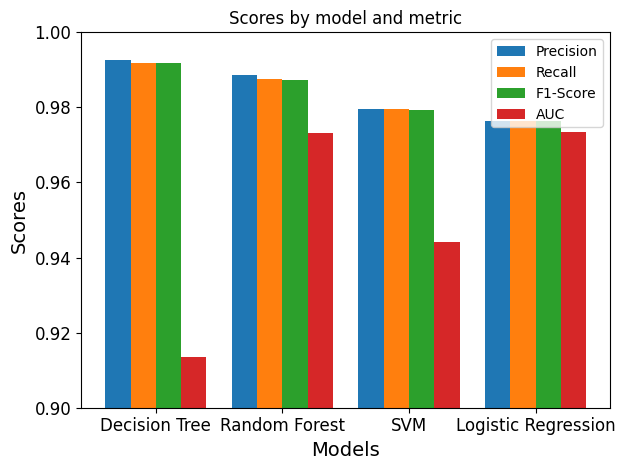

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

models = ['Decision Tree', 'Random Forest', 'SVM', 'Logistic Regression']
precision = [tree_avg_metrics['Precision'], rf_avg_metrics['Precision'], svm_avg_metrics['Precision'], logistic_regression_avg_metrics['Precision']]
recall = [tree_avg_metrics['Recall'], rf_avg_metrics['Recall'], svm_avg_metrics['Recall'], logistic_regression_avg_metrics['Recall']]
f1_score = [tree_avg_metrics['F1-Score'], rf_avg_metrics['F1-Score'], svm_avg_metrics['F1-Score'], logistic_regression_avg_metrics['F1-Score']]
auc = [tree_avg_metrics['AUC'], rf_avg_metrics['AUC'], svm_avg_metrics['AUC'], logistic_regression_avg_metrics['AUC']]
print(models)
print(precision)
print(recall)
print(f1_score)
print(auc)

x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, precision, width, label='Precision')
rects2 = ax.bar(x - 0.5*width, recall, width, label='Recall')
rects3 = ax.bar(x + 0.5*width, f1_score, width, label='F1-Score')
rects4 = ax.bar(x + 1.5*width, auc, width, label='AUC')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Scores by model and metric')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0.9, 1)

fig.tight_layout()

plt.show()

In [52]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Model': models,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1_score,
    'AUC': auc
}

df = pd.DataFrame(data)
df.set_index('Model', inplace=True)

plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap='coolwarm')
plt.title('Model Performance Metrics')
plt.show()



ValueError: setting an array element with a sequence.

<Figure size 800x600 with 0 Axes>